
# Regressão Linear aplicada à Alfabetização no Brasil

## Objetivo
Aplicar regressão linear simples para analisar a relação entre:
- Participação na avaliação (%)
- Alfabetização (%)

Pergunta central:
> A participação na avaliação está associada à taxa de alfabetização?

Base: Dados públicos de alfabetização — Brasil (2024)


In [149]:

# Importação das bibliotecas necessárias

import pandas as pd              # Manipulação de dados
import numpy as np               # Operações matemáticas
import matplotlib.pyplot as plt  # Visualização gráfica

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [150]:
# Baixar planilha oficial do INEP (Alfabetiza Brasil)
url = "https://download.inep.gov.br/alfabetiza_brasil/resultados_e_metas_ufs_2024_2.xlsx"
arquivo = "ica_ufs_2024.xlsx"

!wget -q -O {arquivo} {url}

raw = pd.read_excel(arquivo)

# Remove linha de cabecalho duplicada e seleciona colunas de interesse
raw = raw[raw["ANO DA AVALIAÇÃO"] != "ANO"].copy()

df = raw[
    [
        "PERCENTUAL DE PARTICIPAÇÃO",
        "PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024",
    ]
].rename(
    columns={
        "PERCENTUAL DE PARTICIPAÇÃO": "participacao",
        "PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024": "alfabetizacao",
    }
)

df["participacao"] = pd.to_numeric(df["participacao"], errors="coerce")
df["alfabetizacao"] = pd.to_numeric(df["alfabetizacao"], errors="coerce")
df = df.dropna(subset=["participacao", "alfabetizacao"])

df.head()

,participacao,alfabetizacao
1,87.370000,59.197271
2,80.869222,51.380000
3,93.783968,48.630000
4,79.494774,49.170000
5,89.141494,46.620000


In [151]:

# Informações gerais da base
df.info()

# Estatísticas descritivas
df[['participacao', 'alfabetizacao']].describe()


<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 1 to 28
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   participacao   27 non-null     float64
 1   alfabetizacao  27 non-null     float64
dtypes: float64(2)
memory usage: 648.0 bytes


,participacao,alfabetizacao
count,27.000000,27.000000
mean,87.247832,56.801010
std,6.150335,11.497491
min,70.051040,35.960000
25%,83.164503,48.900000
50%,88.458746,58.130000
75%,90.468582,61.405000
max,98.126774,85.310000


In [152]:

# Definição das variáveis do modelo

X = df[['participacao']]   # Variável explicativa
y = df['alfabetizacao']    # Variável resposta


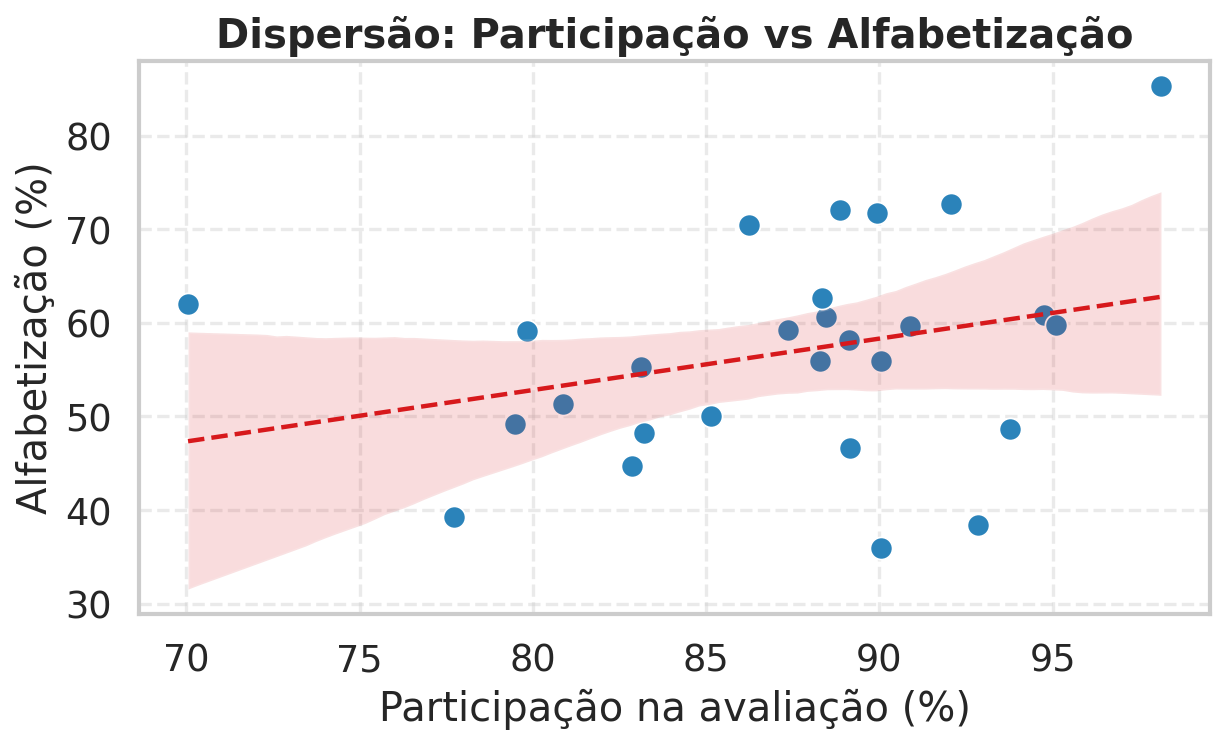

In [153]:
# Gráfico de dispersão para análise exploratória (estilizado)
import seaborn as sns
sns.set_theme(style='whitegrid', context='talk')
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x=X.squeeze(), y=y, color='#2b83ba', s=100, edgecolor='w', linewidth=0.8)
sns.regplot(x=X.squeeze(), y=y, scatter=False, ax=ax, color='#d7191c', line_kws={'linewidth':2, 'linestyle':'--'})
ax.set_xlabel('Participação na avaliação (%)')
ax.set_ylabel('Alfabetização (%)')
ax.set_title('Dispersão: Participação vs Alfabetização')
# adicionar grade leve e margem
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [154]:
 
# Modelos e avaliação mais robusta

import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, HuberRegressor, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, GridSearchCV

# Preparar validação cruzada
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = {
    'Linear': make_pipeline(StandardScaler(), LinearRegression()),
    'Poly2': make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, include_bias=False), LinearRegression()),
    'Ridge': make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    'Huber': make_pipeline(StandardScaler(), HuberRegressor()),
    'RANSAC': make_pipeline(StandardScaler(), RANSACRegressor(random_state=42)),
    'RF': RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []
for name, estimator in models.items():
    # usar MSE negativo para cross_val_score; convertendo depois pra RMSE
    scores_mse = cross_val_score(estimator, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    scores_r2 = cross_val_score(estimator, X, y, scoring='r2', cv=cv, n_jobs=-1)
    rmse_mean = np.sqrt(-scores_mse.mean())
    r2_mean = scores_r2.mean()
    results.append((name, rmse_mean, r2_mean))

results_df = pd.DataFrame(results, columns=['model', 'cv_rmse', 'cv_r2']).sort_values('cv_rmse')
results_df


,model,cv_rmse,cv_r2
1,Poly2,12.456957,-0.973862
2,Ridge,12.510260,-0.932177
0,Linear,12.566874,-0.955409
3,Huber,12.712673,-1.045032
4,RANSAC,12.730498,-1.229683
5,RF,14.047558,-1.387074


In [155]:

# Escolher o melhor modelo (menor CV RMSE) e ajustar em treino/teste para diagnóstico
best_name = results_df.iloc[0]['model']
print(f"Melhor modelo (CV RMSE): {best_name}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = models[best_name]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print(f"Teste RMSE: {test_rmse:.3f}, Teste R2: {test_r2:.3f}")

# Se for um modelo linear simples, mostrar coeficientes
try:
    lr = None
    # extrair do pipeline se existir
    if hasattr(best_model, 'named_steps') and 'linearregression' in best_model.named_steps:
        lr = best_model.named_steps['linearregression']
    elif isinstance(best_model, LinearRegression):
        lr = best_model
    if lr is not None:
        intercept = lr.intercept_
        coef = lr.coef_
        print(f"Equação aproximada: y = {intercept:.3f} + {coef[0]:.3f} * x")
except Exception:
    pass


Melhor modelo (CV RMSE): Poly2
Teste RMSE: 14.672, Teste R2: -5.451
Equação aproximada: y = 50.243 + 4.339 * x


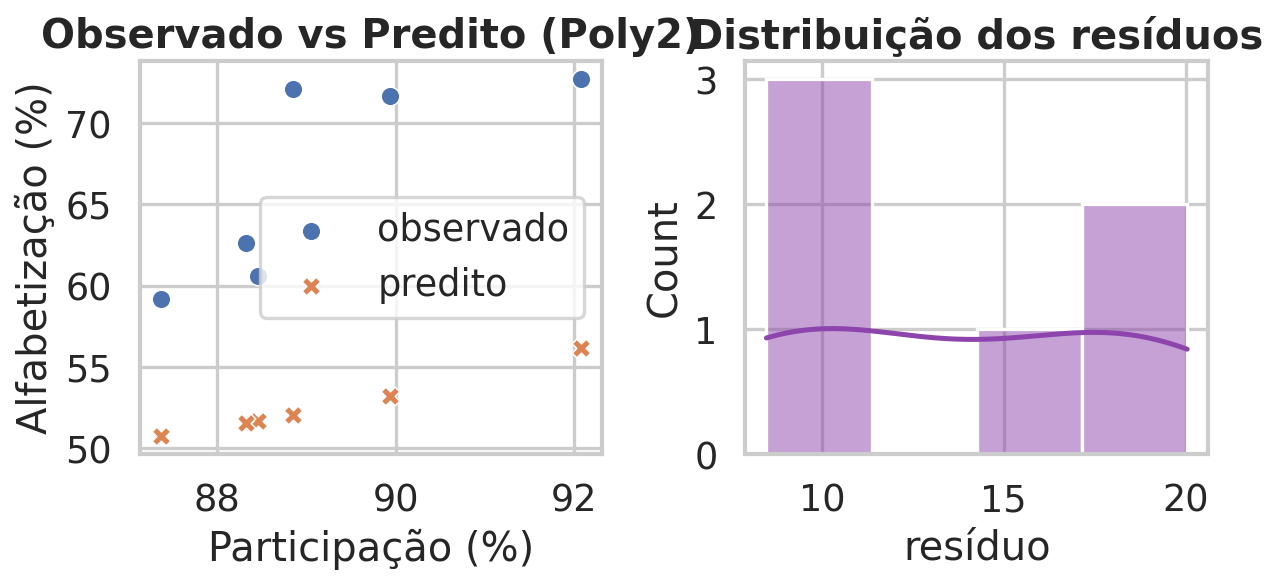

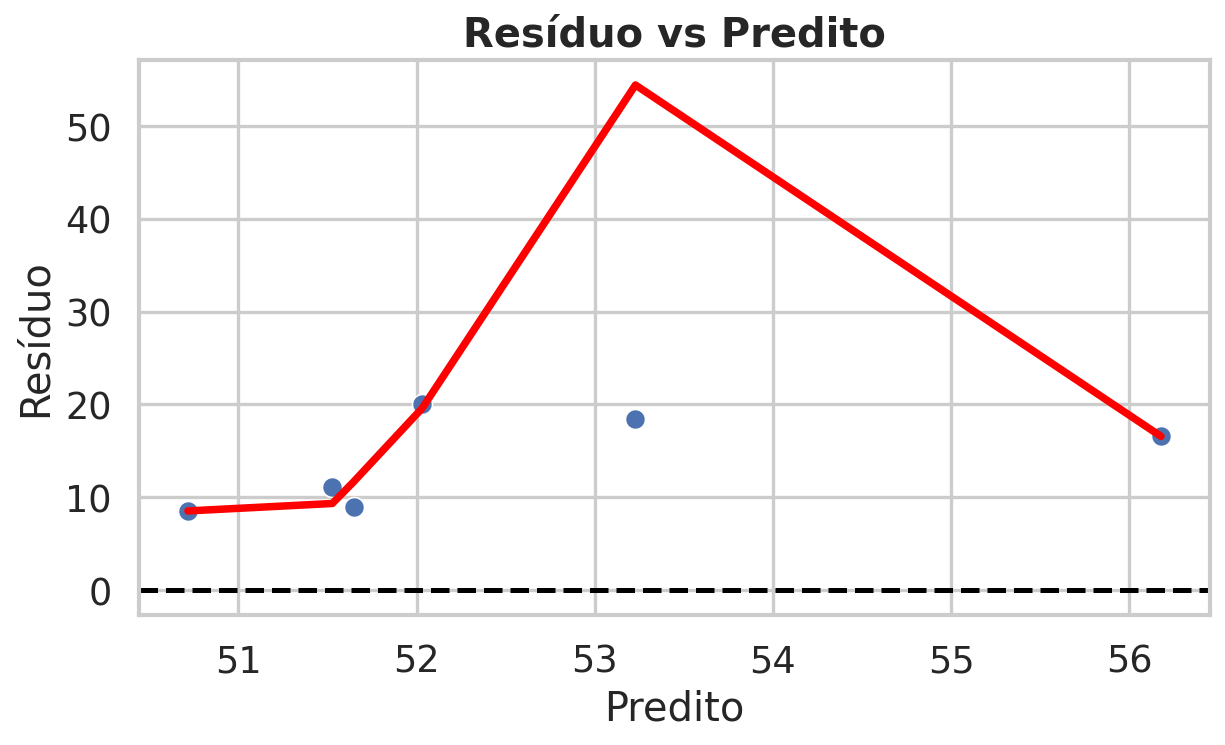

In [156]:
# Diagnóstico: dispersão com previsão e resíduos (estilizado)
import seaborn as sns
sns.set_theme(style='whitegrid', context='talk')
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X_test.squeeze(), y=y_test, label='observado', s=70)
sns.scatterplot(x=X_test.squeeze(), y=y_pred_test, label='predito', s=70, marker='X')
plt.xlabel('Participação (%)')
plt.ylabel('Alfabetização (%)')
plt.title(f'Observado vs Predito ({best_name})')
plt.legend()

plt.subplot(1,2,2)
resid = y_test - y_pred_test
sns.histplot(resid, kde=True, color='#8e44ad')
plt.title('Distribuição dos resíduos')
plt.xlabel('resíduo')

plt.tight_layout()
plt.show()

# Gráfico de resíduos vs preditos com suavização
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_test, y=resid)
sns.regplot(x=y_pred_test, y=resid, scatter=False, lowess=True, line_kws={'color':'red'})
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predito')
plt.ylabel('Resíduo')
plt.title('Resíduo vs Predito')
plt.tight_layout()
plt.show()

In [157]:
# Se o melhor modelo for RandomForest, mostrar importância das variáveis (estilizado)
import seaborn as sns
sns.set_theme(style='whitegrid', context='talk')
if best_name == 'RF':
    rf = best_model if isinstance(best_model, RandomForestRegressor) else best_model
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='Blues_r')
    for i, v in enumerate(feat_imp.values):
        ax.text(v + 0.01, i, f'{v:.2f}', va='center')
    plt.title('Importância das variáveis (RandomForest)')
    plt.xlabel('Importância')
    plt.tight_layout()
    plt.show()

In [158]:
# Inspeção rápida das colunas e possíveis metas
print('Colunas em raw:')
print(list(raw.columns))

if 'ANO DA AVALIAÇÃO' in raw.columns:
    print('Anos encontrados:', raw['ANO DA AVALIAÇÃO'].unique())
else:
    print('Nenhuma coluna de ano encontrada')

cols_meta = [c for c in raw.columns if 'META' in c.upper() or 'ALVO' in c.upper() or 'MÉTA' in c.upper()]
print('Possíveis colunas de meta:', cols_meta)

if cols_meta:
    display(raw[cols_meta].head())
else:
    print('Nenhuma coluna de meta encontrada nas primeiras colunas')

# Mostrar primeiras linhas para inspeção rápida
display(raw.head())

Colunas em raw:
['ANO DA AVALIAÇÃO', 'CÓDIGO UF', 'SIGLA UF', 'NOME UF', 'REDE', 'PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2023', 'PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024', 'META 2024 (2)', 'META 2025', 'META 2026', 'META 2027', 'META 2028', 'META 2029', 'META 2030', 'PERCENTUAL DE PARTICIPAÇÃO']
Anos encontrados: [2024]
Possíveis colunas de meta: ['META 2024 (2)', 'META 2025', 'META 2026', 'META 2027', 'META 2028', 'META 2029', 'META 2030']


,META 2024 (2),META 2025,META 2026,META 2027,META 2028,META 2029,META 2030
1,59.9,63.77,67.47,70.97,74.23,77.24,> 80
2,-,56.9,62.2,67.3,72,76.2,> 80
3,49.7,55.5,61.1,66.5,71.5,76,> 80
4,56.8,61.3,65.6,69.6,73.4,76.9,> 80
5,47.6,53.8,59.9,65.6,70.9,75.8,> 80


,ANO DA AVALIAÇÃO,CÓDIGO UF,SIGLA UF,NOME UF,REDE,PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2023,PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024,META 2024 (2),META 2025,META 2026,META 2027,META 2028,META 2029,META 2030,PERCENTUAL DE PARTICIPAÇÃO
1,2024,NaN,NaN,Brasil,PÚBLICA,55.9,59.197271,59.9,63.77,67.47,70.97,74.23,77.24,> 80,87.37
2,2024,12,AC,Acre,PÚBLICA,-,51.38,-,56.9,62.2,67.3,72,76.2,> 80,80.869222
3,2024,27,AL,Alagoas,PÚBLICA,43.88,48.63,49.7,55.5,61.1,66.5,71.5,76,> 80,93.783968
4,2024,13,AM,Amazonas,PÚBLICA,52.2,49.17,56.8,61.3,65.6,69.6,73.4,76.9,> 80,79.494774
5,2024,16,AP,Amapá,PÚBLICA,41.56,46.62,47.6,53.8,59.9,65.6,70.9,75.8,> 80,89.141494


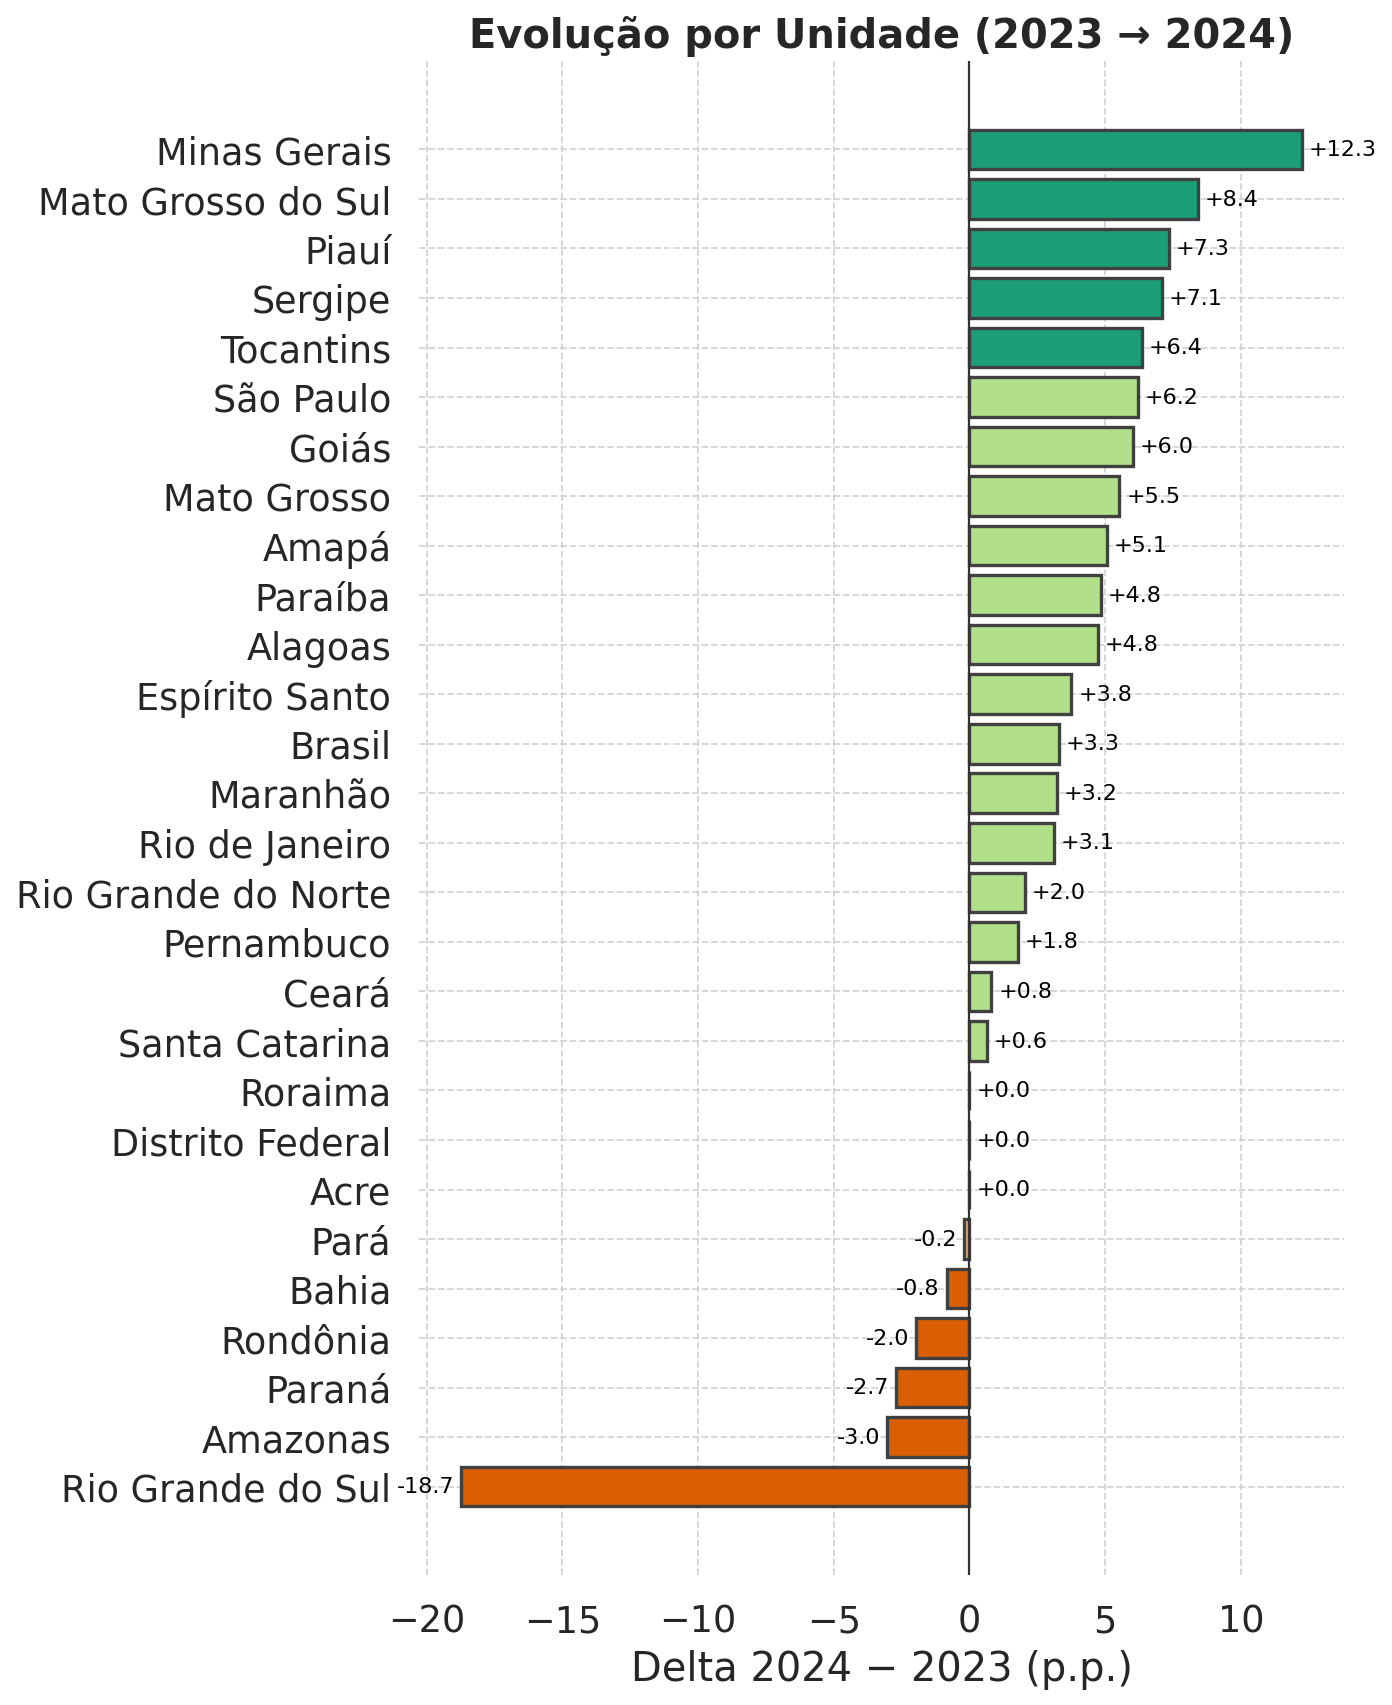

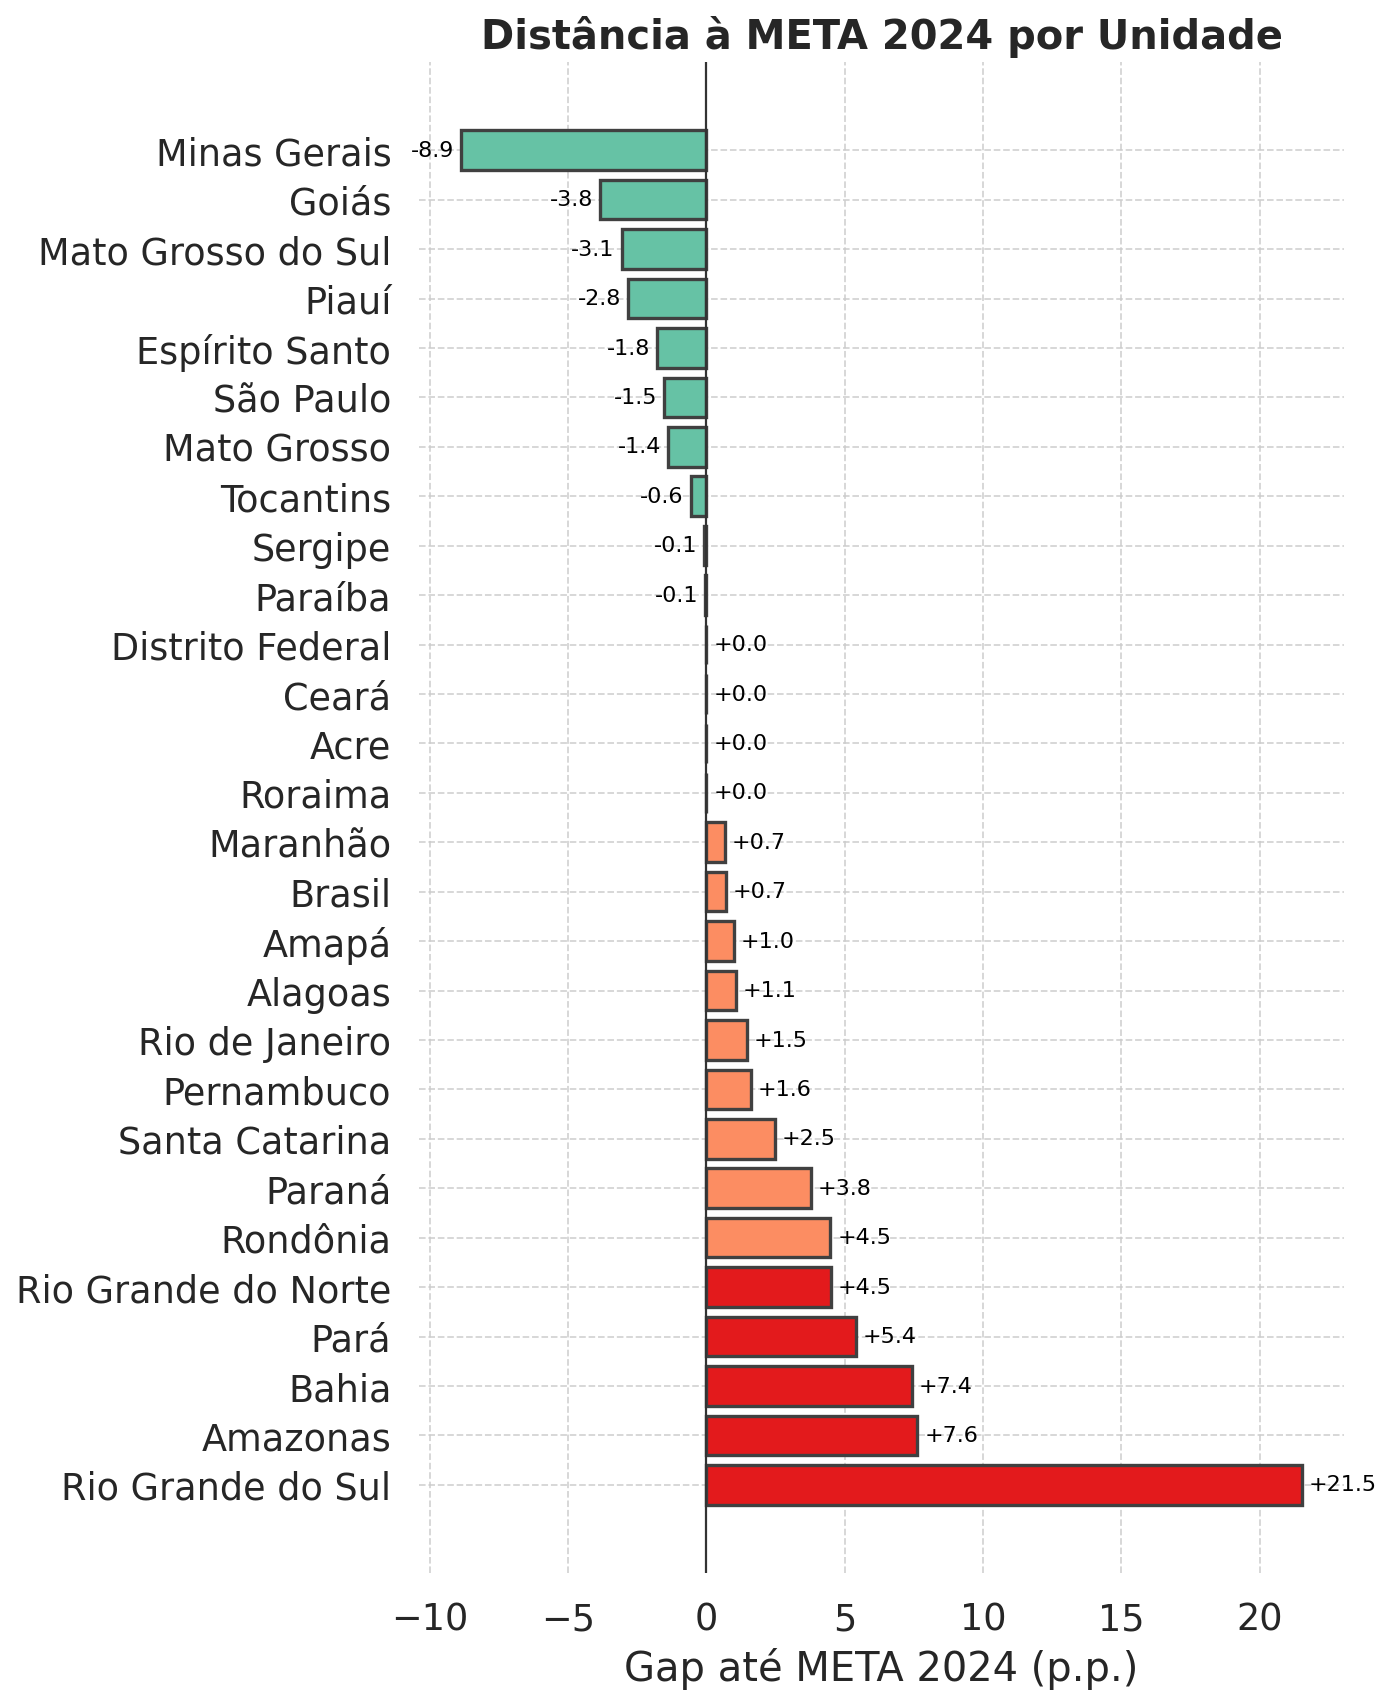

In [159]:
# Plots refinados: barras horizontais ordenadas, destaque nos top5 e anotações claras
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style='whitegrid', context='talk')
mpl.rcParams.update({'figure.dpi':160, 'axes.titleweight':'bold'})

# Preparar dados
plot_df = df2.copy()
plot_df['delta'] = plot_df['delta_23_24'].fillna(0)
plot_df['gap'] = plot_df['gap_to_meta_2024'].fillna(0)

# --- Evolução (delta) ---
# Ordenar para barras horizontais com maior evolução no topo
df_evol = plot_df.sort_values('delta', ascending=True).reset_index(drop=True)
# Cores: positivo verde, negativo vermelho; destaque top5 positivos e top5 negativos
pos_top5 = df_evol[df_evol['delta']>0].nlargest(5, 'delta')['uf'].tolist()
neg_top5 = df_evol[df_evol['delta']<0].nsmallest(5, 'delta')['uf'].tolist()
colors = []
for uf, v in zip(df_evol['uf'], df_evol['delta']):
    if uf in pos_top5:
        colors.append('#1b9e77')  # destaque positivo
    elif uf in neg_top5:
        colors.append('#d95f02')  # destaque negativo
    else:
        colors.append('#b2df8a' if v>0 else '#fdb462')

fig, ax = plt.subplots(figsize=(9, 11))
ax.barh(df_evol['uf'], df_evol['delta'], color=colors, edgecolor='0.25')
# Grid mais opaco (linhas mais visíveis) - aplicar também no eixo y
ax.grid(axis='both', linestyle='--', linewidth=0.8, alpha=0.85)
ax.axvline(0, color='0.2', linewidth=1)
ax.set_xlabel('Delta 2024 − 2023 (p.p.)')
ax.set_title('Evolução por Unidade (2023 → 2024)')
# Anotações: mostrar valor com sinal e um decimal
for i, (val, name) in enumerate(zip(df_evol['delta'], df_evol['uf'])):
    txt = f'{val:+.1f}'
    x = val
    # posição da anotação (esquerda para negativos, direita para positivos)
    if val >= 0:
        ax.text(x + 0.25, i, txt, va='center', ha='left', fontsize=10, color='black')
    else:
        ax.text(x - 0.25, i, txt, va='center', ha='right', fontsize=10, color='black')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('evolucao_por_unidade.png', bbox_inches='tight')
plt.show()

# --- Gap até a meta ---
# Ordenar para que maior gap apareça no topo
# gap >0 significa precisa melhorar; gap <=0 já alcançou
DF = plot_df.sort_values('gap', ascending=True).reset_index(drop=True)
# queremos maior gap no topo -> sort descending
df_gap = plot_df.sort_values('gap', ascending=False).reset_index(drop=True)
# destacar top5 gap (maiores gaps)
top5_gap = df_gap.nlargest(5, 'gap')['uf'].tolist()
colors = []
for uf, v in zip(df_gap['uf'], df_gap['gap']):
    if uf in top5_gap:
        colors.append('#e31a1c')  # destaque maior gap
    else:
        colors.append('#fc8d62' if v>0 else '#66c2a5')

fig, ax = plt.subplots(figsize=(9, 11))
ax.barh(df_gap['uf'], df_gap['gap'], color=colors, edgecolor='0.25')
# Grid mais opaco para facilitar leitura - aplicar também no eixo y
ax.grid(axis='both', linestyle='--', linewidth=0.8, alpha=0.85)
ax.axvline(0, color='0.2', linewidth=1)
ax.set_xlabel('Gap até META 2024 (p.p.)')
ax.set_title('Distância à META 2024 por Unidade')
for i, (val, name) in enumerate(zip(df_gap['gap'], df_gap['uf'])):
    txt = f'{val:+.1f}'
    if val >= 0:
        ax.text(val + 0.25, i, txt, va='center', ha='left', fontsize=10, color='black')
    else:
        ax.text(val - 0.25, i, txt, va='center', ha='right', fontsize=10, color='black')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('gap_meta_por_unidade.png', bbox_inches='tight')
plt.show()

In [160]:
# Respostas diretas: quem evolui mais e quem está mais longe da meta
top_n = 5

# Preparar tabela com métricas já calculadas em df2
summary = df2.copy()
summary = summary[['uf','alf_2023','alf_2024','delta_23_24','meta_2024','gap_to_meta_2024','participacao']]

# Top que mais evoluíram (delta positivo mais alto)
top_evol = summary.sort_values('delta_23_24', ascending=False).head(top_n).reset_index(drop=True)
# Top mais longe da meta (gap positivo maior = maior distância a meta)
top_gap = summary.sort_values('gap_to_meta_2024', ascending=False).head(top_n).reset_index(drop=True)

# Unidades que atingiram ou superaram a meta
achieved_meta = summary[summary['gap_to_meta_2024'] <= 0].sort_values('gap_to_meta_2024')

# Imprimir respostas claras
print(f"Top {top_n} unidades que mais evoluíram (2023->2024):")
for i, row in top_evol.iterrows():
    print(f"{i+1}. {row['uf']}: {row['delta_23_24']:.2f} p.p. (de {row['alf_2023']:.2f}% para {row['alf_2024']:.2f}%)")

print('\nTop {0} unidades mais longe da META 2024 (gap = meta - atual):'.format(top_n))
for i, row in top_gap.iterrows():
    print(f"{i+1}. {row['uf']}: gap {row['gap_to_meta_2024']:.2f} p.p. (meta {row['meta_2024']:.2f}% vs atual {row['alf_2024']:.2f}%)")

print(f"\nNúmero de unidades que já alcançaram/superaram a meta 2024: {len(achieved_meta)}")
if len(achieved_meta)>0:
    print('Lista:')
    for uf in achieved_meta['uf'].tolist():
        print('-', uf)

# Salvar CSVs para análise posterior
top_evol.to_csv('top_evolucao.csv', index=False)
top_gap.to_csv('top_gap_meta.csv', index=False)
summary.to_csv('df2_with_metrics.csv', index=False)
print('\nArquivos salvos: top_evolucao.csv, top_gap_meta.csv, df2_with_metrics.csv')

Top 5 unidades que mais evoluíram (2023->2024):
1. Minas Gerais: 12.26 p.p. (de 59.81% para 72.07%)
2. Mato Grosso do Sul: 8.42 p.p. (de 47.45% para 55.87%)
3. Piauí: 7.34 p.p. (de 52.48% para 59.82%)
4. Sergipe: 7.09 p.p. (de 31.30% para 38.39%)
5. Tocantins: 6.35 p.p. (de 43.72% para 50.07%)

Top 5 unidades mais longe da META 2024 (gap = meta - atual):
1. Rio Grande do Sul: gap 21.53 p.p. (meta 66.20% vs atual 44.67%)
2. Amazonas: gap 7.63 p.p. (meta 56.80% vs atual 49.17%)
3. Bahia: gap 7.44 p.p. (meta 43.40% vs atual 35.96%)
4. Pará: gap 5.40 p.p. (meta 53.60% vs atual 48.20%)
5. Rio Grande do Norte: gap 4.51 p.p. (meta 43.80% vs atual 39.29%)

Número de unidades que já alcançaram/superaram a meta 2024: 10
Lista:
- Minas Gerais
- Goiás
- Mato Grosso do Sul
- Piauí
- Espírito Santo
- São Paulo
- Mato Grosso
- Tocantins
- Sergipe
- Paraíba

Arquivos salvos: top_evolucao.csv, top_gap_meta.csv, df2_with_metrics.csv



## Discussão

A regressão linear simples indica associação positiva entre participação
na avaliação e alfabetização, mas não implica causalidade.

Outros fatores relevantes (renda, infraestrutura, políticas públicas)
não estão incluídos no modelo.
